In [1]:
using Pkg
using Plots
using LinearAlgebra
using DataFrames
default(markerstrokewidth=0, legendfontsize=10, lw=2)


The problem is structured as such:

1. Your program is given a df with columns:
    1. node id  
    2. coordinates (x, y)
    3. Fixed (y/n) - no deformation  
    4. Forces (x, y)
     
 Material Properties (E, height, depth) are given independently of the df \
 Member connections as well are provided (i.e. list of tuple node pairs)
 
2. Solve for deformation by calculating the stiffness matrix and visualize the undeformed and deformed results

Hint:
$F = K*u$, where $K$ is your stiffness matrix and $u$ is your deformation matrix

In [2]:
# simple example/testing case
# 5-node "house"
house_df = DataFrame(
    node_id = 1:5,
    x_position = [0.0, 2.0, 2.0, 0.0, 1.0],
    y_position = [0.0, 0.0, 2.0, 2.0, 3.0],
    fixed_x = [true, true, false, false, false],
    fixed_y= [true, false, false, false, false],
    connections = [(2, 3,4), (1, 3), (1,2, 4, 5), (1, 3, 5), (3, 4)],
    Fx = [0.0, 0.0, 0.0, 0.0, 0.0],        
    Fy = [0.0, 0.0, 0.0, 0.0, -1000.0]     # downward load on roof peak
)


Row,node_id,x_position,y_position,fixed_x,fixed_y,connections,Fx,Fy
,Int64,Float64,Float64,Bool,Bool,Tuple…,Float64,Float64
1,1,0.0,0.0,true,true,"(2, 3, 4)",0.0,0.0
2,2,2.0,0.0,true,false,"(1, 3)",0.0,0.0
3,3,2.0,2.0,false,false,"(1, 2, 4, 5)",0.0,0.0
4,4,0.0,2.0,false,false,"(1, 3, 5)",0.0,0.0
5,5,1.0,3.0,false,false,"(3, 4)",0.0,-1000.0


### **Get Members**

## **Helper Functions for members df**

In [3]:
# define plotting function for visualization
# uses adjacency like building
function get_members(df)
    members = Vector{Tuple{Int,Int}}()
    for i in 1:nrow(df)
        for ch in df.connections[i]
            if ch > i
                push!(members, (i, ch))
            end
        end
    end
    return members
end

function build_adjacency(members::Vector{Tuple{Int,Int}})
    n = maximum(vcat(members...))
    adj = zeros(Int,n, n)
    for (i, j) in members
        adj[i, j] = 1
        adj[j,i] = 1
    end
    return adj
end
#building Members DF helper to accomodate member 
function element_geometry(df, n1, n2)
    x1, y1 = df.x_position[n1], df.y_position[n1]
    x2, y2 = df.x_position[n2], df.y_position[n2]
    dx, dy = x2 - x1, y2 - y1
    L = sqrt(dx^2 + dy^2)
    c, s = dx/L, dy/L
    return L, c, s, dx, dy
end
        

element_geometry (generic function with 1 method)

## **Plotting Functions**

In [4]:
function plot_truss(nodes_df::DataFrame; force_scale=0.001, label_nodes=true)
    plt = plot(; aspect_ratio=1, legend=:outertopright, grid=false)

    # Draw members
    for i in 1:nrow(nodes_df)
        xi, yi = nodes_df.x_position[i], nodes_df.y_position[i]
        for j in nodes_df.connections[i]
            xj, yj = nodes_df.x_position[j], nodes_df.y_position[j]
            plot!(plt, [xi, xj], [yi, yj], color=:black, lw=2, label=false)
        end
    end

    # Track whether we've added legend entries
    added_pin = false
    added_roller = false
    added_node = false

    # Plot supports/nodes
    for i in 1:nrow(nodes_df)
        xi, yi = nodes_df.x_position[i], nodes_df.y_position[i]

        if nodes_df.fixed_x[i] && nodes_df.fixed_y[i]
            scatter!(plt, [xi], [yi];
                     markershape=:utriangle, color=:blue,
                     label=added_pin ? false : "Pin Support")
            added_pin = true
        elseif nodes_df.fixed_x[i] || nodes_df.fixed_y[i]
            scatter!(plt, [xi], [yi];
                     markershape=:circle, color=:blue,
                     label=added_roller ? false : "Roller Support")
            added_roller = true
        else
            scatter!(plt, [xi], [yi];
                     markershape=:circle, color=:black,
                     label=added_node ? false : "Free Node")
            added_node = true
        end
    end

    # Plot applied forces
    for i in 1:nrow(nodes_df)
        Fx, Fy = nodes_df.Fx[i], nodes_df.Fy[i]
        if Fx != 0 || Fy != 0
            quiver!(plt, [nodes_df.x_position[i]], [nodes_df.y_position[i]];
                    quiver=([Fx*force_scale], [Fy*force_scale]),
                    color=:red, label=false)
        end
    end

    return plt
end


plot_truss (generic function with 1 method)

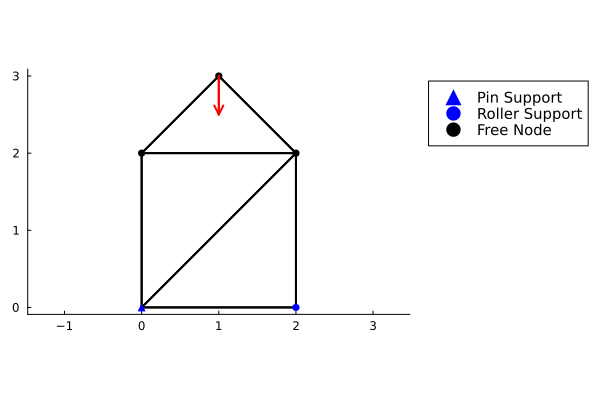

In [5]:
#execute plotting on example
plot_truss(house_df; force_scale=0.0005)   # tweak scaling until arrows look balanced


## Member DF builder

In [6]:
function get_member_df(df::DataFrame, E, A)
    members = get_members(df)
    n_members = length(members)

    dxs, dys, lengths, cs, ss = Float64[], Float64[], Float64[], Float64[], Float64[]

    for (n1, n2) in members
        x1, y1 = df.x_position[n1], df.y_position[n1]
        x2, y2 = df.x_position[n2], df.y_position[n2]
        dx, dy = x2 - x1, y2 - y1
        L = sqrt(dx^2 + dy^2)
        push!(dxs, dx)
        push!(dys, dy)
        push!(lengths, L)
        push!(cs, dx/L)
        push!(ss, dy/L)
    end

    # support scalar or vector E/A
    E_vec = length(E) == 1 ? fill(E, n_members) : E
    A_vec = length(A) == 1 ? fill(A, n_members) : A

    return DataFrame(
        member_id = 1:n_members,
        n1 = [m[1] for m in members],
        n2 = [m[2] for m in members],
        dx = dxs,
        dy = dys,
        length = lengths,
        cos = cs,
        sin = ss,
        E = E_vec,
        A = A_vec
    )
end


get_member_df (generic function with 1 method)

## DOF helper functions
- Adds DOF to node df

In [7]:
#degrees of freedom function
#Takes in df, geometry domain (2D/3D) and type(truss/beam), 
#returns updated df

function dofs_per_node(R::Int, element_type::String)
    if element_type == "truss"
        return R == 2 ? 2 : (R == 3 ? 3 : error("Unsupported dimension"))
    elseif element_type == "beam"
        return R == 2 ? 3 : (R == 3 ? 6 : error("Unsupported dimension"))
    else
        error("Unknown element_type: $element_type")
    end
end    

function add_dofs!(df::DataFrame, R::Int=2, element_type::String="truss")
    per_node = dofs_per_node(R, element_type)
    df.dofs = [ [(per_node*(i-1) + j) for j in 1:per_node] for i in 1:nrow(df) ]
    return df
end

function filter_dofs(node_df::DataFrame, F_len::Int)
    fixed_dofs = Int[]
    for i in 1:nrow(node_df)
        dofs = node_df[!, :dofs][i]
        if node_df[!, :fixed_x][i]
            push!(fixed_dofs, dofs[1])
        end
        if node_df[!, :fixed_y][i]
            push!(fixed_dofs, dofs[2])
        end
    end
    all_dofs = collect(1:F_len)
    return setdiff(all_dofs, fixed_dofs)
end


filter_dofs (generic function with 1 method)

- TODO: ADD IN DERIVATION OF THE STIFFNESS TENSOR STRUCTURE AND WHY THE EVEN AND ODD QUADRANTS MATCH

## **Stiffness Builder**

In [8]:
#define stiffness matrix from FLEA eq
function member_stiffness(member_id::Int, member_df::DataFrame)
    #geometry
    dx = member_df.dx[member_id]
    dy = member_df.dy[member_id]
    L = member_df.length[member_id]
    c = member_df.cos[member_id]
    s = member_df.sin[member_id]
    E = member_df.E[member_id]
    A = member_df.A[member_id]
    k_e = (E*A) / L
    stiffness = k_e * [c^2 c*s -c^2 -c*s;
                     c*s s^2 -c*s -s^2;
                     -c^2 -c*s c^2 c*s;
                    -c*s -s^2 c*s s^2]
    return stiffness
end

function assemble_global_stiffness(nodes_df::DataFrame, members_df::DataFrame)
    ndofs = maximum(vcat(nodes_df.dofs...))  # total DOFs = 2*n_nodes
    K = zeros(Float64, ndofs, ndofs)

    for row in eachrow(members_df)
        n1, n2 = row.n1, row.n2
        ke = member_stiffness(row.member_id, members_df)
        dofs = vcat(nodes_df.dofs[n1], nodes_df.dofs[n2])

        for i in 1:4, j in 1:4
            K[dofs[i], dofs[j]] += ke[i,j]
        end
    end

    return K
end

assemble_global_stiffness (generic function with 1 method)

## **Forces Vector Builder**

In [9]:
function build_force_vector(df::DataFrame; R::Int=2)
    n_nodes = nrow(df)
    ndofs = R * n_nodes
    F = zeros(Float64, ndofs)

    for i in 1:n_nodes
        if R == 2
            F[df.dofs[i][1]] = df.Fx[i]
            F[df.dofs[i][2]] = df.Fy[i]
        elseif R == 3
            F[df.dofs[i][1]] = df.Fx[i]
            F[df.dofs[i][2]] = df.Fy[i]
            F[df.dofs[i][3]] = df.Fz[i]
        else
            error("Only R=2 or R=3 supported")
        end
    end

    return F
end

build_force_vector (generic function with 1 method)

## **The MATRIX METHOD**
### $K* \overrightarrow{u}= \overrightarrow{F}$
**Rearranging becomes:**
### $\overrightarrow{u} = K^{-1} * \overrightarrow{F}$

In [10]:
function get_displacement_vector(nodes_df::DataFrame, E, A; R::Int=2)
    # assign DOFs to nodes
    nodes_df = add_dofs!(nodes_df; R=R, element_type="truss")

    # build members DataFrame
    member_df = get_member_df(nodes_df, E, A)

    # assemble global stiffness matrix
    global_stiffness = assemble_global_stiffness(nodes_df, member_df)

    # build force vector
    Force_vec = build_force_vector(nodes_df; R=R)

    # free DOFs (exclude fixed)
    free_dofs = filter_dofs(nodes_df,length(Force_vec))

    # reduced system
    K_reduced = global_stiffness[free_dofs, free_dofs]
    F_reduced = Force_vec[free_dofs]

    # solve for free DOFs
    u_reduced = K_reduced \ F_reduced

    # full displacement vector (zeros at fixed DOFs)
    u = zeros(length(Force_vec))
    u[free_dofs] .= u_reduced

    return u
end


function node_displaced_position(nodes_df::DataFrame, u::Vector{Float64}; scale=1.0)
    n_nodes = nrow(nodes_df)

    # extract displacements for each node
    ux = [u[nodes_df.dofs[i][1]] for i in 1:n_nodes]
    uy = [u[nodes_df.dofs[i][2]] for i in 1:n_nodes]

    return DataFrame(
        node_id     = nodes_df.node_id,
        x_orig      = nodes_df.x_position,
        y_orig      = nodes_df.y_position,
        x_deformed  = nodes_df.x_position .+ scale .* ux,
        y_deformed  = nodes_df.y_position .+ scale .* uy,
        connections = nodes_df.connections,
        fixed       = nodes_df.fixed
    )
end

function build_deformed_nodes_df(nodes_df::DataFrame, u::Vector{Float64}; scale=50.0)
    n_nodes = nrow(nodes_df)
    ux = [u[nodes_df.dofs[i][1]] for i in 1:n_nodes]
    uy = [u[nodes_df.dofs[i][2]] for i in 1:n_nodes]

    return DataFrame(
        node_id    = nodes_df.node_id,
        x_position = nodes_df.x_position .+ scale .* ux,
        y_position = nodes_df.y_position .+ scale .* uy,
        connections = nodes_df.connections,
        fixed_x      = nodes_df.fixed_x,
        fixed_y = nodes_df.fixed_y,
    )
end




build_deformed_nodes_df (generic function with 1 method)

In [11]:
"""
    solve_truss(nodes_df, E, A; R=2)

High-level wrapper: build members, assemble K, build F, apply BCs,
and solve for displacements. Returns global displacement vector u.
"""
function solve_truss(nodes_df::DataFrame, E, A; R::Int=2)
    # assign DOFs
    add_dofs!(nodes_df, R, "truss")

    # build members
    member_df = get_member_df(nodes_df, E, A)

    # assemble global stiffness
    K = assemble_global_stiffness(nodes_df, member_df)

    # build global force vector
    F = build_force_vector(nodes_df; R=R)

    # find free DOFs
    free_dofs = filter_dofs(nodes_df, length(F))

    # reduced system
    K_reduced = K[free_dofs, free_dofs]
    F_reduced = F[free_dofs]

    #check
    println("Fixed DOFs: ", setdiff(1:length(F), free_dofs))
    println("Force vector: ", F)
    println("Sum of forces: ", sum(F))
    println("K_reduced size: ", size(K_reduced))
    println("Rank(K_reduced): ", rank(K_reduced))
    # solve for free DOFs
    u_reduced = K_reduced \ F_reduced

    # build full displacement vector
    u = zeros(length(F))
    u[free_dofs] .= u_reduced

    return u, member_df
end


solve_truss

# **Postprocess deformation and extract axial loads for each member**

In [12]:
function get_deformed_member_df(node_df::DataFrame, deformed_nodes::DataFrame, member_df::DataFrame)
    dx = node_df.x_position - deformed_nodes.x_position
    dy = node_df.y_position - deformed_nodes.y_position
    deformed_

LoadError: ParseError:
[90m# Error @ [0;0m]8;;file:///Users/elliotporter/Desktop/mtx_methods/code/personal/In[12]#4:14\[90mIn[12]:4:14[0;0m]8;;\
    dy = node_df.y_position - deformed_nodes.y_position
    deformed_[48;2;120;70;70m[0;0m
[90m#            └ ── [0;0m[91mExpected `end`[0;0m

Fixed DOFs: [1, 2, 3]
Force vector: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1000.0]
Sum of forces: -1000.0
K_reduced size: (7, 7)
Rank(K_reduced): 6
Global displacement vector u:
[0.0, 0.0, 0.0, 1.1231801037651505e9, -1.1231801037651517e9, 1.1231801037651505e9, -1.1231801037651522e9, -4.878846992586676e-7, -1.6847701556477275e9, 5.615900518825741e8]

Deformed node coordinates:
5×6 DataFrame
 Row │ node_id  x_position   y_position  connections   fixed_x  fixed_y 
     │ Int64    Float64      Float64     Tuple…        Bool     Bool    
─────┼──────────────────────────────────────────────────────────────────
   1 │       1   0.0         0.0         (2, 3, 4)        true     true
   2 │       2   2.0         5.6159e10   (1, 3)           true    false
   3 │       3  -5.6159e10   5.6159e10   (1, 2, 4, 5)    false    false
   4 │       4  -5.6159e10   1.99998     (1, 3, 5)       false    false
   5 │       5  -8.42385e10  2.80795e10  (3, 4)          false    false


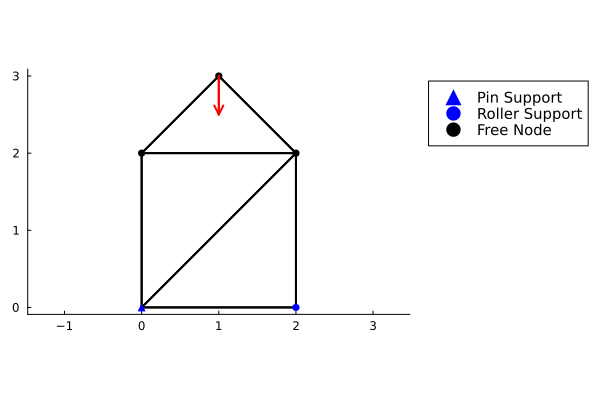

LoadError: UndefVarError: `plot_truss_forces` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [13]:
# --- Material and section properties ---
E = 200e9   # Young's modulus [Pa]
A = 0.01    # Cross-sectional area [m^2]



# --- Solve full truss system ---
u_house, member_house_df = solve_truss(house_df, E, A; R=2)

println("Global displacement vector u:")
println(u_house)

# --- Build deformed node table for plotting ---
deformed_house_df = build_deformed_nodes_df(house_df, u_house; scale=50.0)

println("\nDeformed node coordinates:")
println(deformed_house_df)

# --- Plot undeformed geometry ---
plt_house = plot_truss(house_df; force_scale=0.0005)
display(plt_house)

# --- Plot deformed with axial forces ---
plt_house_forces = plot_truss_forces(house_df, member_house_df, u_house;
                                     scale=50.0, show=:force)
display(plt_house_forces)


# **PRATT TRUSS TESTING**

In [14]:
using DataFrames

# Node layout (meters)
node_id   = 1:6
x_position = [0.0, 2.0, 4.0, 6.0, 2.0, 4.0]
y_position = [0.0, 0.0, 0.0, 0.0, 2.0, 2.0]

# Supports: Node 1 fixed, Node 4 roller (only y fixed)
fixed_x = [true, false, false, false, false, false]
fixed_y = [true, false, false, true, false, false]
# Connections (adjacency by node_id, 1-based)
connections = [
    (2, 5),     # node 1 connects to node 2, 5
    (1, 3, 5),  # node 2 connects to 1, 3, 5
    (2, 4, 6),  # node 3 connects to 2, 4, 6
    (3, 6),     # node 4 connects to 3, 6
    (1, 2, 6),  # node 5 connects to 1, 2, 6
    (3, 4, 5)   # node 6 connects to 3, 4, 5
]

# Load: downward at top mid node (node 5)
Fx = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Fy = [0.0, 0.0, 0.0, 0.0, 0.0, -1000.0]

pratt_df = DataFrame(node_id=node_id,
                     x_position=x_position,
                     y_position=y_position,
                     fixed_x=fixed_x,
                     fixed_y=fixed_y,
                     connections=connections,
                     Fx=Fx, Fy=Fy)


Row,node_id,x_position,y_position,fixed_x,fixed_y,connections,Fx,Fy
,Int64,Float64,Float64,Bool,Bool,Tuple…,Float64,Float64
1,1,0.0,0.0,true,true,"(2, 5)",0.0,0.0
2,2,2.0,0.0,false,false,"(1, 3, 5)",0.0,0.0
3,3,4.0,0.0,false,false,"(2, 4, 6)",0.0,0.0
4,4,6.0,0.0,false,true,"(3, 6)",0.0,0.0
5,5,2.0,2.0,false,false,"(1, 2, 6)",0.0,0.0
6,6,4.0,2.0,false,false,"(3, 4, 5)",0.0,-1000.0


Fixed DOFs: [1, 2, 8]
Force vector: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1000.0]
Sum of forces: -1000.0
K_reduced size: (9, 9)
Rank(K_reduced): 8
Global displacement vector u:
[0.0, 0.0, 1.5367087579748585e-5, 5.249780445432606e11, 3.073417515949717e-5, -5.2497804454326074e11, 4.6101262739245756e-5, 0.0, -5.249780445432606e11, 5.249780445432606e11, -5.249780445432606e11, -5.2497804454326074e11]

Deformed node coordinates:
6×6 DataFrame
 Row │ node_id  x_position   y_position   connections  fixed_x  fixed_y 
     │ Int64    Float64      Float64      Tuple…       Bool     Bool    
─────┼──────────────────────────────────────────────────────────────────
   1 │       1   0.0          0.0         (2, 5)          true     true
   2 │       2   2.00307      1.04996e14  (1, 3, 5)      false    false
   3 │       3   4.00615     -1.04996e14  (2, 4, 6)      false    false
   4 │       4   6.00922      0.0         (3, 6)         false     true
   5 │       5  -1.04996e14   1.0

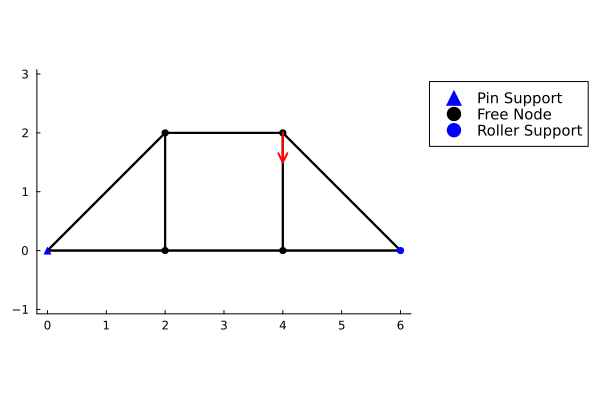

LoadError: UndefVarError: `plot_truss_forces` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [15]:
E = 200e9    # Pa
A = 5e-4     # m²

pratt_u, p_member_df = solve_truss(pratt_df, E, A; R=2)
println("Global displacement vector u:")
println(pratt_u)
deformed_pratt_df = build_deformed_nodes_df(pratt_df, pratt_u; scale=200.0)
println("\nDeformed node coordinates:")
println(deformed_pratt_df)
#
#plot_truss
# --- Plot undeformed geometry ---
plt_pratt = plot_truss(pratt_df; force_scale=0.0005)
display(plt_pratt)

# --- Plot deformed with axial forces ---
plt_prat_forces = plot_truss_forces(pratt_df, p_member_df, pratt_u;
                                     scale=50.0, show=:force)
display(plt_prat_forces)
